In [1]:
!pip install kaggle
!kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
!unzip german-traffic-sign-detection-benchmark-gtsdb.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
License(s): unknown
 99% 1.60G/1.61G [00:18<00:00, 163MB/s]
100% 1.61G/1.61G [00:18<00:00, 91.2MB/s]
Archive:  german-traffic-sign-detection-benchmark-gtsdb.zip
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00000.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00001.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00002.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00003.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00004.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00005.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00006.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00007.ppm  
  inflating: /content/dataset/TestIJCNN2013/TestIJCNN2013Download/00008.ppm  
  inflating: /content/dataset/Te

In [2]:
!pip install --upgrade torchvision


In [3]:
import seaborn as sns
import pandas as pd
import numpy as np

import os
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image, ImageDraw

from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import random
import cv2
from matplotlib import pyplot as plt
from torchvision.ops import box_iou
import math
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN

Training set size: (404, 800, 1360, 3), 404, 404
Test set size: (102, 800, 1360, 3), 102, 102
Epoch [1/6], Loss: 0.5744
Epoch [2/6], Loss: 0.4196
Epoch [3/6], Loss: 0.3364
Epoch [4/6], Loss: 0.2940
Epoch [5/6], Loss: 0.2617
Epoch [6/6], Loss: 0.2286
Mean IoU: 0.5562
Mean Average Precision: 6.7727


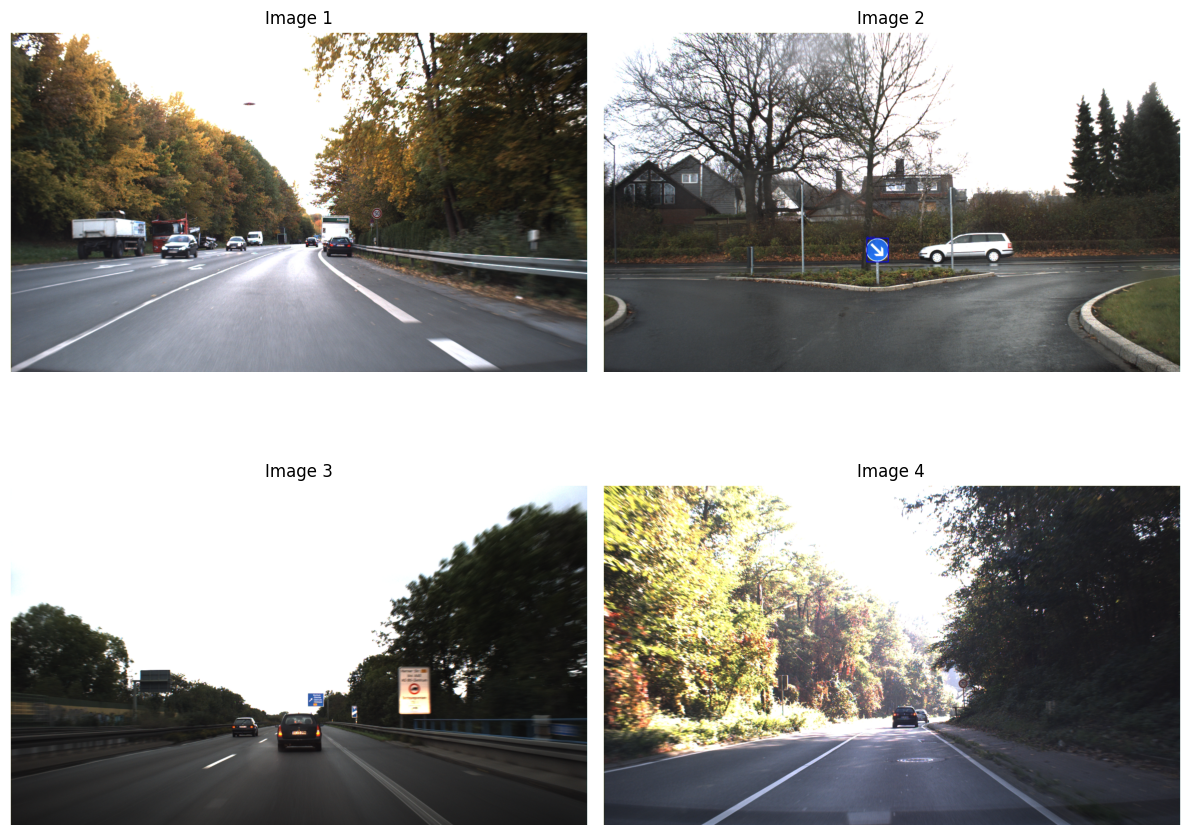

In [6]:
# Load annotations from dataset
annotations_dict = {'bounding_boxes': [], 'labels': []}

file_path = '/content/dataset/gt.txt'
data_dir = "/content/dataset/TrainIJCNN2013/TrainIJCNN2013"

image_list = []
label_list = []
bbox_list = []
label_values = []
current_image_name = ''

with open(file_path, 'r') as file:
    for line in file:
        data = line.strip().split(';')
        img_name = data[0]
        base_name = img_name.split('.')[0]

        if current_image_name != base_name:
            current_image_name = base_name
            annotations_dict['bounding_boxes'] = bbox_list
            annotations_dict['labels'] = label_values
            label_list.append(annotations_dict)
            annotations_dict = {'bounding_boxes': [], 'labels': []}
            bbox_list = []
            label_values = []
            img = Image.open(os.path.join(data_dir, img_name))
            image_list.append(img)

        bbox_list.append([int(coord) for coord in data[1:5]])
        label_values.append(int(data[5]))

# Append final image annotations
annotations_dict['bounding_boxes'] = bbox_list
annotations_dict['labels'] = label_values
label_list.append(annotations_dict)
label_list.pop(0)

# Image processing: Resize images
resized_images = [np.array(img.resize((1360, 800))) for img in image_list]

# Prepare annotations for processed data
processed_annotations = [
    {'labels': annotation['labels'], 'bounding_boxes': annotation['bounding_boxes']}
    for annotation in label_list
]

# Split data into training and testing sets
train_imgs, test_imgs, train_annos, test_annos = train_test_split(
    resized_images, processed_annotations, test_size=0.2, random_state=42
)

# Separate labels and bounding boxes for training and testing
train_labels = [anno['labels'] for anno in train_annos]
train_bboxes = [anno['bounding_boxes'] for anno in train_annos]
test_labels = [anno['labels'] for anno in test_annos]
test_bboxes = [anno['bounding_boxes'] for anno in test_annos]

# Convert images into numpy arrays for compatibility with models
train_imgs = np.array(train_imgs)
test_imgs = np.array(test_imgs)

print(f"Training set size: {train_imgs.shape}, {len(train_labels)}, {len(train_bboxes)}")
print(f"Test set size: {test_imgs.shape}, {len(test_labels)}, {len(test_bboxes)}")


# Define custom dataset class
class CustomGTSDBDataset(Dataset):
    def __init__(self, images, annotations, transform=None):
        self.images = images
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        annotation = self.annotations[idx]
        bbox_tensor = torch.as_tensor(annotation['bounding_boxes'], dtype=torch.float32)
        label_tensor = torch.as_tensor(annotation['labels'], dtype=torch.int64)

        target = {"boxes": bbox_tensor, "labels": label_tensor}
        if self.transform:
            img = self.transform(img)
        return F.to_tensor(img), target

# Instantiate datasets and dataloaders
train_data = CustomGTSDBDataset(train_imgs, train_annos)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

test_data = CustomGTSDBDataset(test_imgs, test_annos)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# Count unique class labels
all_labels = [label for entry in label_list for label in entry['labels']]
label_count = Counter(all_labels)
num_classes = len(label_count) + 1  # Add 1 for background class

'''
    Loading the pre-trained model <>
'''
# Load pre-trained Faster R-CNN model with ResNet-50 backbone
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Adjust the classifier head to match the number of classes
in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
faster_rcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
faster_rcnn_model.to(device)


# Setup optimizer
params = [param for param in faster_rcnn_model.parameters() if param.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
epochs = 6
for epoch in range(epochs):
    faster_rcnn_model.train()
    total_loss = 0

    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{key: value.to(device) for key, value in target.items()} for target in targets]

        loss_dict = faster_rcnn_model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    torch.save(faster_rcnn_model.state_dict(), f'frcnn_epoch_{epoch + 1}.pth')

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")


# Evaluation - IoU and mAP
faster_rcnn_model.eval()
iou_scores = []
avg_precisions = []

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = [img.to(device) for img in imgs]
        predictions = faster_rcnn_model(imgs)

        for i, prediction in enumerate(predictions):
            pred_boxes = prediction['boxes'].cpu()
            true_boxes = targets[i]['boxes']

            iou = box_iou(pred_boxes, true_boxes)
            iou_scores.append(iou.mean().item())

            precision = len(pred_boxes) / max(len(true_boxes), 1)
            avg_precisions.append(precision)

# Mean IoU and mAP
mean_iou = np.mean(iou_scores)
mean_ap = np.mean(avg_precisions)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Average Precision: {mean_ap:.4f}")


# Visualize predictions with bounding boxes
def visualize_predictions(model, data_loader, device, num_images=4):
    model.eval()
    images, targets = next(iter(data_loader))
    images = [img.to(device) for img in images]

    with torch.no_grad():
        predictions = model(images)

    num_rows = math.ceil(num_images / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 5))
    axes = axes.flatten()

    for i in range(min(num_images, len(images))):
        image_tensor = images[i].cpu().permute(1, 2, 0).numpy()
        image_pil = Image.fromarray((image_tensor * 255).astype(np.uint8))

        draw = ImageDraw.Draw(image_pil)

        for box, score in zip(predictions[i]['boxes'], predictions[i]['scores']):
            if score >= 0.5:
                x1, y1, x2, y2 = box.int().cpu().numpy()
                draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
                draw.text((x1, y1 - 5), f"{score:.2f}", fill="blue")

        axes[i].imshow(image_pil)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i + 1}")

    plt.tight_layout()
    plt.show()

# Usage example
visualize_predictions(faster_rcnn_model, test_loader, device)


In [ ]:
import torchvision.ops as ops

# Evaluation - IoU, mAP, and NMS
faster_rcnn_model.eval()
iou_scores = []
avg_precisions = []

nms_threshold = 0.5  # IoU threshold for NMS
score_threshold = 0.5  # Confidence score threshold for predictions

with torch.no_grad():
    for imgs, targets in test_loader:
        imgs = [img.to(device) for img in imgs]
        predictions = faster_rcnn_model(imgs)

        for i, prediction in enumerate(predictions):
            pred_boxes = prediction['boxes'].cpu()
            pred_scores = prediction['scores'].cpu()
            true_boxes = targets[i]['boxes']

            #  NMS to reduce duplicate detections
            keep = ops.nms(pred_boxes, pred_scores, nms_threshold)
            filtered_boxes = pred_boxes[keep]
            filtered_scores = pred_scores[keep]

            #  IoU for filtered predictions
            iou = box_iou(filtered_boxes, true_boxes)
            iou_scores.append(iou.mean().item())

            # precision: number of correct predictions / total predicted boxes
            precision = len(filtered_boxes) / max(len(true_boxes), 1)
            avg_precisions.append(precision)

# Mean IoU and mAP
mean_iou = np.mean(iou_scores)
mean_ap = np.mean(avg_precisions)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Average Precision: {mean_ap:.4f}")


Mean IoU: 0.4643
Mean Average Precision: 1.8160


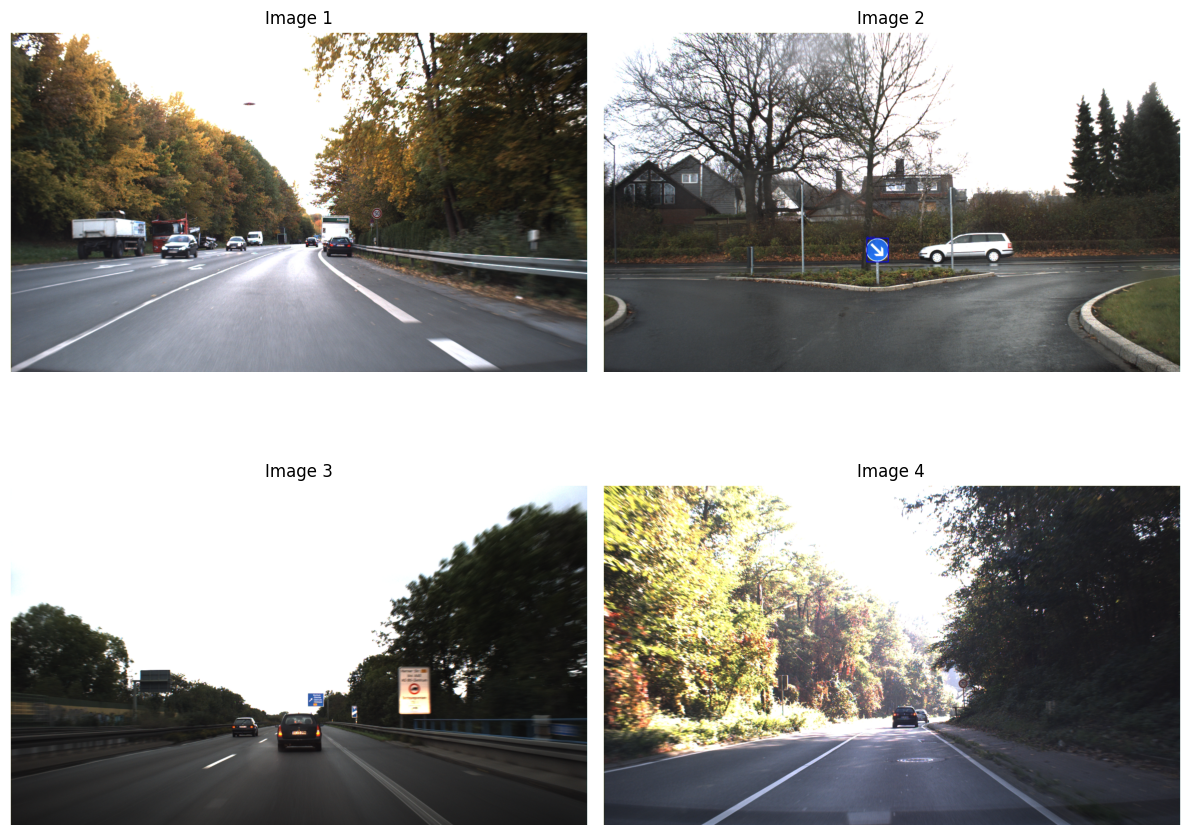

In [ ]:
def visualize_predictions(model, data_loader, device, num_images=4):
    model.eval()
    images, targets = next(iter(data_loader))
    images = [img.to(device) for img in images]

    with torch.no_grad():
        predictions = model(images)

    num_rows = math.ceil(num_images / 2)
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 5))
    axes = axes.flatten()

    for i in range(min(num_images, len(images))):
        image_tensor = images[i].cpu().permute(1, 2, 0).numpy()
        image_pil = Image.fromarray((image_tensor * 255).astype(np.uint8))

        draw = ImageDraw.Draw(image_pil)

        #  NMS to remove duplicate boxes
        pred_boxes = predictions[i]['boxes']
        pred_scores = predictions[i]['scores']
        keep = ops.nms(pred_boxes, pred_scores, nms_threshold)
        filtered_boxes = pred_boxes[keep]
        filtered_scores = pred_scores[keep]

        # Draw filtered boxes with scores
        for box, score in zip(filtered_boxes, filtered_scores):
            if score >= 0.5:  
                x1, y1, x2, y2 = box.int().cpu().numpy()
                draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
                draw.text((x1, y1 - 5), f"{score:.2f}", fill="blue")

        axes[i].imshow(image_pil)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i + 1}")

    plt.tight_layout()
    plt.show()


visualize_predictions(faster_rcnn_model, test_loader, device)
